In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
import glob
from xml.etree import ElementTree

In [10]:
#Read Images and the faces annotations
annotations_directory = r'C:/Users/Halimah/Documents/ML_course/MLProject/DataSet/annotations'
images_directory = r'C:/Users/Halimah/Documents/ML_course/MLProject/DataSet/images/'

In [11]:
#This part of reading annotation and applying them to the images is taken from https://www.kaggle.com/code/akashkirodiwal/face-mask-detection-using-cnn
information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [], 'file': [], 'width': [], 'height': []}

for annotation in glob.glob(annotations_directory + '/*.xml'):
    tree = ElementTree.parse(annotation)
    
    for element in tree.iter():
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag: 
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))    

        if 'object' in element.tag:
            for attribute in list(element):
                
                if 'name' in attribute.tag:
                    name = attribute.text                 
                    information['label'] += [name]
                    information['width'] += [width]
                    information['height'] += [height] 
                    information['file'] += [annotation.split('/')[-1][12:-4]] 
                            
                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            information['xmin'] += [xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            information['ymin'] += [ymin]                                
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            information['xmax'] += [xmax]                                
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            information['ymax'] += [ymax]

In [12]:
#Create dataframe with the annotation info
annotations_info_df = pd.DataFrame(information)
annotations_info_df.head(10)

,xmin,ymin,xmax,ymax,label,file,width,height
0,79,105,109,142,without_mask,maksssksksss0,512,366
1,185,100,226,144,with_mask,maksssksksss0,512,366
2,325,90,360,141,without_mask,maksssksksss0,512,366
3,321,34,354,69,with_mask,maksssksksss1,400,156
4,224,38,261,73,with_mask,maksssksksss1,400,156
5,299,58,315,81,with_mask,maksssksksss1,400,156
6,143,74,174,115,with_mask,maksssksksss1,400,156
7,74,69,95,99,with_mask,maksssksksss1,400,156
8,191,67,221,93,with_mask,maksssksksss1,400,156
9,21,73,44,93,with_mask,maksssksksss1,400,156


In [13]:
# Add Annotation and Image File Names
annotations_info_df['annotation_file'] = annotations_info_df['file'] + '.xml'
annotations_info_df['image_file'] = annotations_info_df['file'] + '.png'

# Tidy Grammatical Issue for lable 'mask_weared_incorrect' to 'mask_incorrectly_worn'
annotations_info_df.loc[annotations_info_df['label'] == 'mask_weared_incorrect', 'label'] = 'mask_incorrectly_worn'

annotations_info_df.head(10)

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file
0,79,105,109,142,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
1,185,100,226,144,with_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
2,325,90,360,141,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
3,321,34,354,69,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
4,224,38,261,73,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
5,299,58,315,81,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
6,143,74,174,115,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
7,74,69,95,99,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
8,191,67,221,93,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
9,21,73,44,93,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png


In [14]:
#Function to Apply annotations on images (Taken from: )https://www.kaggle.com/code/akashkirodiwal/face-mask-detection-using-cnn
def render_image(image_path):
    image = cv2.imread(image_path)
    img=image_path.split('/')[-1]
    #print(image.shape)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bound_box=[]
    for i in annotations_info_df[annotations_info_df['image_file']==img].index:
        (x,y,width,height)=(annotations_info_df.loc[i].xmin,annotations_info_df.loc[i].ymin,
                        annotations_info_df.loc[i].xmax,annotations_info_df.loc[i].ymax)
        bound_box.append((x,y,width,height))  
        if annotations_info_df.loc[i].label=='with_mask':
            cv2.rectangle(image, (x,y), (x+width, y+height), (0, 200, 0), 2)
            cv2.putText(image, org = (x-8 , y-8), text = "Mask", 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (0, 200, 0))
        elif annotations_info_df.loc[i].label=='mask_incorrectly_worn':
            cv2.rectangle(image, (x,y), (x+width, y+height), (255, 255, 0), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'Incorrect', 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (255, 255, 0))
        else:
            cv2.rectangle(image, (x,y), (x+width, y+height), (200, 0, 0), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'No mask', 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (200, 0, 0))
        
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()
    
    return bound_box,image

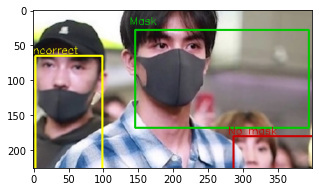

([(3, 65, 96, 163), (146, 28, 249, 140), (287, 180, 343, 225)],
 array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [149, 143, 125],
         [149, 143, 125],
         [149, 143, 125]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [149, 143, 125],
         [149, 143, 125],
         [149, 143, 125]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [149, 143, 125],
         [149, 143, 125],
         [149, 143, 125]],
 
        ...,
 
        [[ 89,  81,  80],
         [ 85,  77,  76],
         [255, 255,   0],
         ...,
         [115, 100,  74],
         [142, 127,  93],
         [166, 148, 110]],
 
        [[ 88,  80,  79],
         [ 83,  75,  74],
         [255, 255,   0],
         ...,
         [ 64,  53,  30],
         [ 94,  81,  52],
         [130, 114,  81]],
 
        [[ 88,  80,  79],
         [ 82,  74,  73],
    

In [36]:
#annotations_info_df = pd.read_csv('cropped_df.csv') 
#render_image(r'C:/Users/Halimah/Documents/ML_course/MLProject/DataSet/images/maksssksksss307.png')
render_image('DataSet/images/maksssksksss307.png')

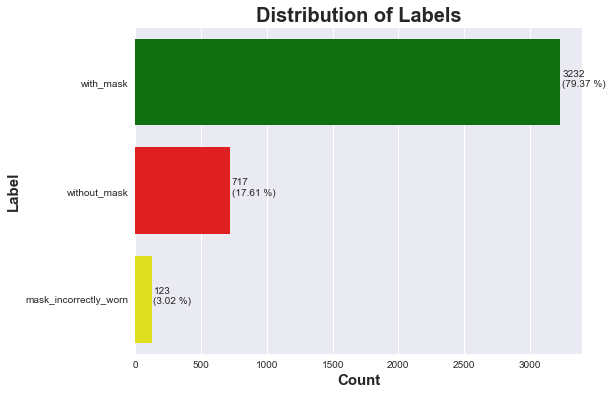

In [42]:
label_df = pd.DataFrame(annotations_info_df['label'].value_counts()).reset_index()
label_df.rename(columns = {'index': 'label', 'label': 'count'}, inplace = True)

plt.style.use('seaborn')
plt.figure(figsize = (8, 6))
barplot = sns.barplot(x = 'count', y = 'label', data = label_df ,  
                      palette = ['green', 'red', 'yellow'])
plt.title('Distribution of Labels', fontsize = 20, fontweight = 'bold')
plt.xlabel('Count', fontsize = 15, fontweight = 'bold')
plt.ylabel('Label', fontsize = 15, fontweight = 'bold')

for p in barplot.patches:
    width = p.get_width()
    percentage = round(width * 100 / sum(label_df['count']), 2)
    plt.text(x = width + 15, y = p.get_y() + 0.55 * p.get_height(), s = f'{int(width)}\n({percentage} %)')

plt.show()


In [24]:
#Add another column in our data frame fror the cropped images names
annotations_info_df['cropped_image_file'] = annotations_info_df['file'] #Will be the same as the annotation file name and will change it later in a loop while cropping
annotations_info_df

#os.mkdir('cropped_images') #Create directory for the cropped images

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,79,105,109,142,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0
1,185,100,226,144,with_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0
2,325,90,360,141,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0
3,321,34,354,69,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1
4,224,38,261,73,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1
...,...,...,...,...,...,...,...,...,...,...,...
4067,263,62,287,85,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png,maksssksksss98
4068,344,80,377,106,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png,maksssksksss98
4069,181,54,273,162,mask_incorrectly_worn,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png,maksssksksss99
4070,99,87,176,165,with_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png,maksssksksss99


In [ ]:
#########Image Cropping ################## 
for i in range(len(annotations_info_df)):
    # Get The File Path and Read The Image
    image_filepath = images_directory + annotations_info_df['image_file'].iloc[i]
    image = cv2.imread(image_filepath)
    
    # Set The Cropped Image File Name
    annotations_info_df['cropped_image_file'].iloc[i] = annotations_info_df['cropped_image_file'].iloc[i] + '-' + str(i) + '.png'
    cropped_image_filename = annotations_info_df['cropped_image_file'].iloc[i]
    
    # Get The xmin, ymin, xmax, ymax Value (Bounding Box) to Crop Image
    xmin = annotations_info_df['xmin'].iloc[i]
    ymin = annotations_info_df['ymin'].iloc[i]
    xmax = annotations_info_df['xmax'].iloc[i]
    ymax = annotations_info_df['ymax'].iloc[i]

    # Crop The Image Based on The Values Above
    cropped_image = image[ymin:ymax, xmin:xmax]
    
    cropped_image_directory = os.path.join('./cropped_images', cropped_image_filename) 
    cv2.imwrite(cropped_image_directory, cropped_image)

In [28]:
annotations_info_df.to_csv('cropped_df.csv')
################################# Cropping Done here, Next is cropped images pre-processing #####################

In [9]:
df_all = pd.read_csv('cropped_df.csv') 

In [16]:
#Create new dataframe with 'cropped_image_file' and 'label' only. Other columns are not required
df_cropped = df_all[['cropped_image_file', 'label']].copy()
df_cropped

,cropped_image_file,label
0,maksssksksss0-0.png,without_mask
1,maksssksksss0-1.png,with_mask
2,maksssksksss0-2.png,without_mask
3,maksssksksss1-3.png,with_mask
4,maksssksksss1-4.png,with_mask
...,...,...
4067,maksssksksss98-4067.png,with_mask
4068,maksssksksss98-4068.png,with_mask
4069,maksssksksss99-4069.png,mask_incorrectly_worn
4070,maksssksksss99-4070.png,with_mask


In [33]:
#########The parts below to chech image width and height and drop images with width or height less than 10
#add cropped image width and height 
for i in range(len(df_cropped)):
    cropped_image_path = './cropped_images/' + df_cropped['cropped_image_file'].iloc[i]
    cropped_image = cv2.imread(cropped_image_path)
    df_cropped.loc [i, 'image_width'] = (cropped_image.shape[0])
    df_cropped.loc [i, 'image_height'] = (cropped_image.shape[1])

In [58]:
#Drop rows with image width or image width less than 10
df_cropped.drop(df_cropped[df_cropped.image_width<10].index , axis =0 ,  inplace = True)

In [59]:
#Drop rows with image height or image width less than 10
df_cropped.drop(df_cropped[df_cropped.image_height<10].index , axis =0 ,  inplace = True)

In [60]:
np.size(df_cropped['image_width'])

3603

In [61]:
(df_cropped['label']).value_counts()

with_mask                2877
without_mask              608
mask_incorrectly_worn     118
Name: label, dtype: int64

In [62]:
df_cropped.to_csv('cropped_dfV2.csv')